Quenching a random product state
-----

First we'll set up a 20 qubit random product state, and a sparse heisenberg hamiltonian to evolve it with:

In [1]:
import quimb as qu

n = 20
H = qu.ham_heis(n, sparse=True).real
psi0 = qu.rand_product_state(n)

We can do a few checks on the system:

In [2]:
# check normalization
qu.expectation(psi0, psi0)

1.0000000000000004

In [3]:
# find the initial energy
qu.expec(H, psi0)

-0.12535206633341608

In [4]:
# find the initial variance in energy
psi0.H @ H @ H @ psi0

matrix([[2.96936808+7.56339436e-16j]])

Let's compare this to the total energy spectrum of the Hamiltonian ``H``:

In [5]:
%%time
print(qu.bound_spectrum(H))

(-8.904386529876453, 4.9999999999999964)
CPU times: user 2.13 s, sys: 1.02 s, total: 3.16 s
Wall time: 24.9 s


We can speed up that computation by taking advantage of the fact that ``H`` conserves z-spin and so projecting it into the 0 magnetization subspace:

In [6]:
%%time
prj = qu.zspin_projector(n=20, sz=0)
print(qu.bound_spectrum(prj @ H @ prj.H))

(-8.904386529876446, 5.000000000000006)
CPU times: user 1.1 s, sys: 184 ms, total: 1.29 s
Wall time: 4.01 s


A lot quicker! And we can infer that our initial state has overlap between many states in the centre of the spectrum.

Evolution
---------

Now let's set up some things we want to compute while we evolve with the hamiltonian. Namely the logarithmic negativity and mutual information between neighbouring qubits. Since we'll use the default adaptive integrating scheme, we'll return the current time as well:

In [7]:
def compute(t, pt):
    """Perform computation at time ``t`` with state ``pt``.
    """
    dims = [2] * n
    lns = [qu.logneg_subsys(pt, dims, i, i + 1) for i in range(n - 1)]
    mis = [qu.mutinf_subsys(pt, dims, i, i + 1) for i in range(n - 1)]
    return t, lns, mis

Set up the evolution with the initial state, hamiltonian and the compute dict:

In [8]:
evo = qu.Evolution(psi0, H, compute=compute, progbar=True)

Update the evolution to ``t=5``. The functions in ``compute`` will be called at each step the integrator uses. If we had set ``method='solve'`` or ``method='expm'``, we should use the generator ``evo.at_times(ts)`` to specify the time steps when computation takes place.

In [9]:
evo.update_to(5)

100%|██████████| 100/100 [00:35<00:00,  3.07%/s]


We can extract the results of the computation from ``evo.results`` and plot them:

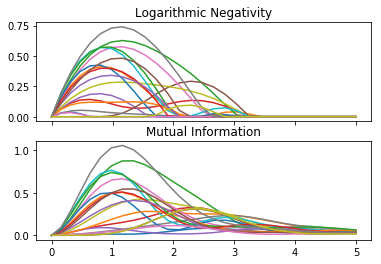

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

ts, lns, mis = zip(*evo.results)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ts, lns);
axs[0].set_title("Logarithmic Negativity")
axs[1].plot(ts, mis);
axs[1].set_title("Mutual Information")

plt.show()

We can see that the classical correlations outlast the quantum correlations.

Finally, let's check that energy has been conserved in the current state at ``t=5``:

In [11]:
qu.expec(H, evo.pt)

-0.12535194635655628